**Ładowanie danych i preprocessing**


In [1]:
#importy
import pickle
import abc
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from sklearn.metrics import f1_score
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sn
import random

In [2]:
# Wczytanie zbioru danych
dataset_path = 'drive/My Drive/dataset.pkl'

with open(dataset_path, 'rb') as f:
    dataset = pickle.load(f)

def load_x_y(ds_type):
    images = dataset[ds_type]['X']
    labels = dataset[ds_type]['y']
    return images, labels

# Ustawienie ziarna
tf.random.set_seed(1234)
def data_preprocessing(images, labels):
    # Zmiana rozmiaru obrazu z 224x224 do 64x64
    images = tf.image.resize(
        images, [64, 64], 
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR, 
        preserve_aspect_ratio=False,
        name=None
    )
    # Spłaszczenie obrazu do jednego wymiaru (np. z 64x64x3 do 12288)
    #images = tf.reshape(images, [images.shape[0],-1])
    # Zmiana typu obrazów z int na float i normalizacja wartości pikseli z przedziału 0-255 do przedziału 0-1
    images = tf.cast(images, tf.float32) / 255.0
    # Zmiana wymiarowości z [8870] na [8870, 1] w celu zastosowania `SparseCategoricalCrossentropy`
    labels = tf.reshape(labels, [-1, 1])
    
    return images, labels

# Do iterowania zbioru danych i podzielenia na paczki (ang. batch) można wykorzystać interfejs zdefiniowany w `tensorflow.data.Dataset`
def create_ds(images, labels, batch_size=100):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels)) 
    dataset = dataset.shuffle(buffer_size=len(images)).batch(batch_size=batch_size)
    return dataset

In [4]:
images_train, labels_train = load_x_y('train')
images_train, labels_train = data_preprocessing(images_train, labels_train)
train_ds = create_ds(images_train, labels_train)

images_test_before, labels_test = load_x_y('test')
images_test, labels_test = data_preprocessing(images_test_before, labels_test)
test_ds = create_ds(images_test, labels_test)

images_val, labels_val = load_x_y('validation')
images_val, labels_val = data_preprocessing(images_val, labels_val)
val_ds = create_ds(images_val, labels_val)

**Rozwiązanie - architektura sieci**

In [36]:
class CNN(tf.keras.Model):
    def __init__(self,kernel_size, pool_size, pooling = tf.keras.layers.MaxPooling2D, rate = 0.2):
        super(CNN, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=64, activation='relu',kernel_size=kernel_size, strides=(1, 1), input_shape=(64, 64, 3))
        self.max_pool1 = pooling(pool_size=pool_size, strides=(2, 2))
        self.conv2 = tf.keras.layers.Conv2D(filters=64, activation='relu',kernel_size=kernel_size, strides=(1, 1))
        self.max_pool2 = pooling(pool_size=pool_size, strides=(2, 2))
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(units=384, activation='relu')
        self.fc2 = tf.keras.layers.Dense(units=192, activation='relu')
        self.fc3 = tf.keras.layers.Dense(units=14, activation='softmax')
        self.dropout = tf.keras.layers.Dropout(rate)

        
    def call(self, inputs, training=False, dropout = False):
        x = inputs
        if dropout == True:
            x = self.dropout(x)
        x = self.conv1(inputs)
        x = self.max_pool1(x)
        if dropout == True:
            x = self.dropout(x)
        x = self.conv2(x)
        x = self.max_pool2(x)
        x = self.flatten(x)
        if dropout == True:
            x = self.dropout(x)
        x = self.fc1(x)
        if dropout == True:
            x = self.dropout(x)
        x = self.fc2(x)
        if dropout == True:
            x = self.dropout(x)
        x = self.fc3(x)
        return x

    def augmentation(self, x, transformation=0):
        if transformation == 0:
            transformation = random.randint(1, 3)
        if transformation == 1:
            x = tf.image.flip_left_right(x)
        elif transformation == 2:
            x = tf.image.rot90(x)
        elif transformation == 3:
            x = tf.image.random_brightness(x, 0.2)
            x = tf.image.random_contrast(x, 0.2, 0.5)
            x = tf.image.random_saturation(x, 5, 10)
        return x

    def fit(self, **kwargs):
        self.epoch_loss_train = []
        self.epoch_f1_train = []
        self.epoch_loss_val = []
        self.epoch_f1_val = []
        self.epoch_loss_test = []
        self.epoch_f1_test = []
        train_ds = kwargs.get("train_ds", None)
        batch_size = kwargs.get("batch_size", 100)
        lr = kwargs.get("lr", 0.001)
        wd = kwargs.get("wd", None)
        epoch_num = kwargs.get("epoch_num", 25)
        optimizer = kwargs.get("optimizer", tf.keras.optimizers.Adam)
        if wd is not None:
            optimizer = optimizer(weight_decay=wd, learning_rate=lr)
        else:
            optimizer = optimizer(learning_rate=lr)
        cost_func = kwargs.get('cost_func', tf.keras.losses.SparseCategoricalCrossentropy())
        val_ds = kwargs.get("val_ds", None)
        test_ds = kwargs.get("test_ds", None)
        aug = kwargs.get("augementation", 0)
        drop = kwargs.get("drop", False)
        for epoch in range(epoch_num):
            print("\nStart of epoch %d" % (epoch,))
            f1_train = tfa.metrics.F1Score(num_classes=14, average="macro")
            f1_val = tfa.metrics.F1Score(num_classes=14, average="macro")
            f1_test = tfa.metrics.F1Score(num_classes=14, average="macro")
            #TRAIN
            for x, y in train_ds:
                if random.random() > 0.6:
                    x = self.augmentation(x)
                with tf.GradientTape() as tape:
                    logits = self.call(x, dropout = drop)
                    loss = cost_func(y, logits)
                grads = tape.gradient(loss, self.trainable_weights)
                optimizer.apply_gradients(zip(grads, self.trainable_weights))
                f1_train.update_state(tf.squeeze(tf.one_hot(y, depth=14)), 
                                   tf.one_hot(tf.argmax(logits, axis=-1), 
                                    depth=14))
            self.epoch_loss_train.append(loss)
            self.epoch_f1_train.append(f1_train.result())
            #TEST
            for x, y in test_ds:
                logits = self.call(x)
                loss = cost_func(y, logits)
                f1_test.update_state(tf.squeeze(tf.one_hot(y, depth=14)), 
                                   tf.one_hot(tf.argmax(logits, axis=-1), 
                                    depth=14))
            self.epoch_loss_test.append(loss)
            self.epoch_f1_test.append(f1_test.result())
            #VALIDATION
            for x, y in val_ds:
                logits = self.call(x)
                loss = cost_func(y, logits)
                f1_val.update_state(tf.squeeze(tf.one_hot(y, depth=14)), 
                                   tf.one_hot(tf.argmax(logits, axis=-1), 
                                    depth=14))
                
            self.epoch_loss_val.append(loss)
            self.epoch_f1_val.append(f1_val.result())
            print("TRAIN: Loss ={:.3f}, F1 ={:.3f}".format(self.epoch_loss_train[-1],self.epoch_f1_train[-1]))
            print("TEST: Loss ={:.3f}, F1 ={:.3f}".format(self.epoch_loss_test[-1],self.epoch_f1_test[-1]))
            print("VALIDATION: Loss ={:.3f}, F1 ={:.3f}".format(self.epoch_loss_val[-1],self.epoch_f1_val[-1]))
    

    def predict(self, x):
        logits = self.call(x)
        return logits
        

**Eksperymenty**

In [32]:
def run_experiments(epoch, lr, optimizer, batch_size, kernel_size, pool_size, pooling, aug, drop, wd, rate):
    model = CNN(kernel_size = kernel_size, pool_size = pool_size, pooling=pooling, rate = rate)
    train_ds = create_ds(images_train, labels_train, batch_size)
    val_ds = create_ds(images_val, labels_val)
    test_ds = create_ds(images_test, labels_test, batch_size)
    model.fit(train_ds = train_ds, test_ds = test_ds, val_ds = val_ds, epoch_num = epoch, 
              lr = lr, optimizer = optimizer, batch_size = batch_size, augmentation = aug, drop = drop, wd = wd)
    y_pred = model.predict(images_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_true = labels_test
    f1 = f1_score(y_true, y_pred, average='micro')
    print("PARAMS: ", epoch, lr, optimizer, batch_size, kernel_size, pool_size, pooling)
    print("LOSS: {:.3f}".format(model.epoch_loss_train[-1]))
    print("F1:", f1)
    return model, f1

In [24]:
result = pd.DataFrame(columns=['augementation', 'f1'])
for aug in range (0,4):
    model, f1 = run_experiments(30, 0.0001, tf.keras.optimizers.Adam, 100, (5,5), (4,4), tf.keras.layers.MaxPooling2D, aug)
    result = result.append({'augementation' : aug, 'f1': f1}, 
                                   ignore_index=True)
with open('results.csv', 'a') as f:
    result.to_csv(f, header=False)
#Best results - rotation


Start of epoch 0
TRAIN: Loss =2.400, F1 =0.031
TEST: Loss =2.510, F1 =0.043
VALIDATION: Loss =2.398, F1 =0.042

Start of epoch 1
TRAIN: Loss =2.398, F1 =0.082
TEST: Loss =2.475, F1 =0.114
VALIDATION: Loss =2.410, F1 =0.117

Start of epoch 2
TRAIN: Loss =2.304, F1 =0.148
TEST: Loss =2.277, F1 =0.176
VALIDATION: Loss =2.375, F1 =0.171

Start of epoch 3
TRAIN: Loss =2.253, F1 =0.187
TEST: Loss =2.278, F1 =0.210
VALIDATION: Loss =2.357, F1 =0.208

Start of epoch 4
TRAIN: Loss =2.097, F1 =0.190
TEST: Loss =2.301, F1 =0.205
VALIDATION: Loss =2.122, F1 =0.202

Start of epoch 5
TRAIN: Loss =2.594, F1 =0.217
TEST: Loss =2.107, F1 =0.214
VALIDATION: Loss =2.033, F1 =0.210

Start of epoch 6
TRAIN: Loss =2.152, F1 =0.216
TEST: Loss =2.210, F1 =0.211
VALIDATION: Loss =2.104, F1 =0.217

Start of epoch 7
TRAIN: Loss =2.152, F1 =0.214
TEST: Loss =2.083, F1 =0.219
VALIDATION: Loss =2.089, F1 =0.222

Start of epoch 8
TRAIN: Loss =2.382, F1 =0.229
TEST: Loss =2.250, F1 =0.215
VALIDATION: Loss =2.226, F1

In [42]:
result = pd.DataFrame(columns=['regularization', 'rate', 'f1'])
rates = [0.1, 0.2, 0.5]
for rate in rates:
    model, f1 = run_experiments(30, 0.0001, tf.keras.optimizers.Adam, 100, (5,5), (4,4), 
                              tf.keras.layers.MaxPooling2D, 2, True, None, rate)
    result = result.append({'regularization' : 'dropout', 'rate':rate, 'f1': f1}, 
                                   ignore_index=True)
with open('results2.csv', 'a') as f:
    result.to_csv(f, header=False)


Start of epoch 0
TRAIN: Loss =2.536, F1 =0.037
TEST: Loss =2.517, F1 =0.047
VALIDATION: Loss =2.418, F1 =0.046

Start of epoch 1
TRAIN: Loss =2.407, F1 =0.115
TEST: Loss =2.247, F1 =0.127
VALIDATION: Loss =2.373, F1 =0.119

Start of epoch 2
TRAIN: Loss =2.127, F1 =0.137
TEST: Loss =2.239, F1 =0.157
VALIDATION: Loss =2.292, F1 =0.151

Start of epoch 3
TRAIN: Loss =2.512, F1 =0.176
TEST: Loss =2.227, F1 =0.177
VALIDATION: Loss =2.154, F1 =0.182

Start of epoch 4
TRAIN: Loss =2.283, F1 =0.176
TEST: Loss =2.117, F1 =0.220
VALIDATION: Loss =2.210, F1 =0.232

Start of epoch 5
TRAIN: Loss =2.131, F1 =0.206
TEST: Loss =2.249, F1 =0.217
VALIDATION: Loss =2.108, F1 =0.218

Start of epoch 6
TRAIN: Loss =2.019, F1 =0.227
TEST: Loss =2.282, F1 =0.223
VALIDATION: Loss =2.206, F1 =0.225

Start of epoch 7
TRAIN: Loss =2.698, F1 =0.234
TEST: Loss =2.162, F1 =0.220
VALIDATION: Loss =2.125, F1 =0.222

Start of epoch 8
TRAIN: Loss =1.966, F1 =0.247
TEST: Loss =2.067, F1 =0.257
VALIDATION: Loss =2.085, F1

In [43]:
result = pd.DataFrame(columns=['regularization', 'rate', 'f1'])
wds = [0.001, 0.0001, 0.00001]
for wd in wds:
    model, f1 = run_experiments(30, 0.0001, tfa.optimizers.AdamW, 100, (5,5), (4,4), 
                              tf.keras.layers.MaxPooling2D, 2, False, wd, 0)
    result = result.append({'regularization' : 'weight decay', 'rate':wd, 'f1': f1}, 
                                   ignore_index=True)
with open('results3.csv', 'a') as f:
    result.to_csv(f, header=False)


Start of epoch 0
TRAIN: Loss =2.433, F1 =0.039
TEST: Loss =2.428, F1 =0.062
VALIDATION: Loss =2.499, F1 =0.065

Start of epoch 1
TRAIN: Loss =2.469, F1 =0.068
TEST: Loss =2.502, F1 =0.078
VALIDATION: Loss =2.369, F1 =0.072

Start of epoch 2
TRAIN: Loss =2.402, F1 =0.098
TEST: Loss =2.334, F1 =0.106
VALIDATION: Loss =2.466, F1 =0.098

Start of epoch 3
TRAIN: Loss =2.651, F1 =0.127
TEST: Loss =2.368, F1 =0.158
VALIDATION: Loss =2.251, F1 =0.149

Start of epoch 4
TRAIN: Loss =2.189, F1 =0.149
TEST: Loss =2.227, F1 =0.174
VALIDATION: Loss =2.360, F1 =0.167

Start of epoch 5
TRAIN: Loss =2.280, F1 =0.151
TEST: Loss =2.295, F1 =0.165
VALIDATION: Loss =2.278, F1 =0.156

Start of epoch 6
TRAIN: Loss =2.385, F1 =0.164
TEST: Loss =2.367, F1 =0.148
VALIDATION: Loss =2.230, F1 =0.141

Start of epoch 7
TRAIN: Loss =2.288, F1 =0.151
TEST: Loss =2.282, F1 =0.151
VALIDATION: Loss =2.233, F1 =0.144

Start of epoch 8
TRAIN: Loss =2.359, F1 =0.157
TEST: Loss =2.160, F1 =0.187
VALIDATION: Loss =2.254, F1

In [50]:
#najlepszy model 
model, f1 = run_experiments(30, 0.0001, tf.keras.optimizers.Adam, 100, (5,5), (4,4), 
                              tf.keras.layers.MaxPooling2D, 2, True, None, 0.5)


Start of epoch 0
TRAIN: Loss =2.411, F1 =0.042
TEST: Loss =2.465, F1 =0.070
VALIDATION: Loss =2.420, F1 =0.072

Start of epoch 1
TRAIN: Loss =2.751, F1 =0.100
TEST: Loss =2.366, F1 =0.136
VALIDATION: Loss =2.498, F1 =0.138

Start of epoch 2
TRAIN: Loss =2.247, F1 =0.151
TEST: Loss =2.114, F1 =0.194
VALIDATION: Loss =2.114, F1 =0.181

Start of epoch 3
TRAIN: Loss =2.090, F1 =0.182
TEST: Loss =2.207, F1 =0.194
VALIDATION: Loss =2.243, F1 =0.180

Start of epoch 4
TRAIN: Loss =2.373, F1 =0.191
TEST: Loss =2.245, F1 =0.194
VALIDATION: Loss =2.159, F1 =0.188

Start of epoch 5
TRAIN: Loss =2.044, F1 =0.212
TEST: Loss =2.206, F1 =0.177
VALIDATION: Loss =2.304, F1 =0.164

Start of epoch 6
TRAIN: Loss =2.363, F1 =0.201
TEST: Loss =2.018, F1 =0.228
VALIDATION: Loss =2.019, F1 =0.229

Start of epoch 7
TRAIN: Loss =1.939, F1 =0.230
TEST: Loss =2.148, F1 =0.250
VALIDATION: Loss =1.985, F1 =0.256

Start of epoch 8
TRAIN: Loss =2.125, F1 =0.258
TEST: Loss =2.007, F1 =0.269
VALIDATION: Loss =2.072, F1

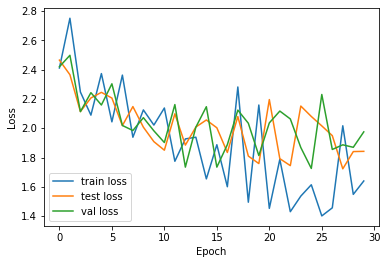

In [51]:
plt.plot(model.epoch_loss_train, label = 'train loss')
plt.plot(model.epoch_loss_test, label = 'test loss')
plt.plot(model.epoch_loss_val, label = 'val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower left')

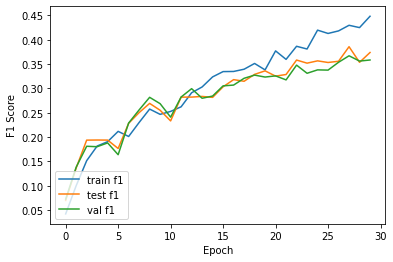

In [52]:
plt.plot(model.epoch_f1_train, label = 'train f1')
plt.plot(model.epoch_f1_test, label = 'test f1')
plt.plot(model.epoch_f1_val, label = 'val f1')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend(loc='lower left')

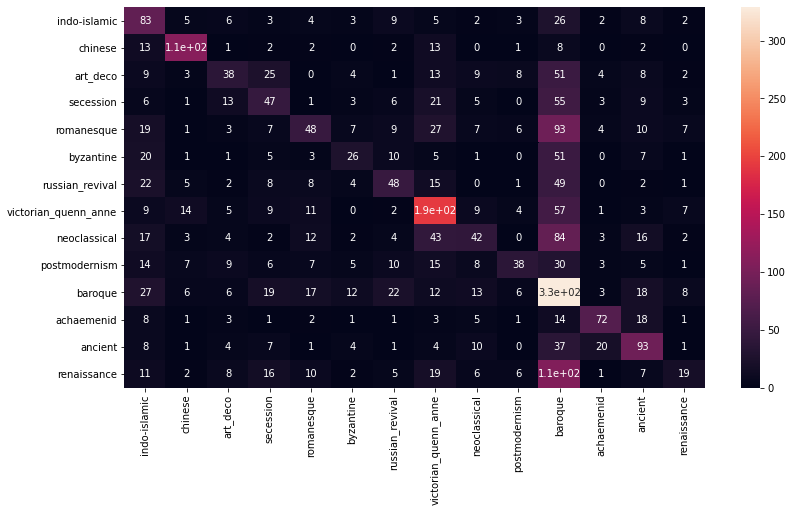

In [53]:
labels = list(dataset['labels_mapping'].keys())
y_pred = model.predict(images_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = labels_test
cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm, index = [i for i in labels],
                  columns = [i for i in labels])
plt.figure(figsize = (13,7))
sn.heatmap(df_cm, annot=True)

In [54]:
def show_image(image, correct, predicted):
    plt.imshow(image)
    plt.title(f'Correct: {correct} Predicted: {predicted}')
    plt.show()

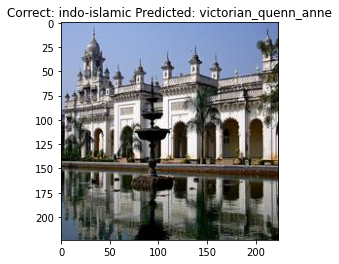

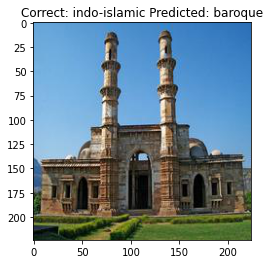

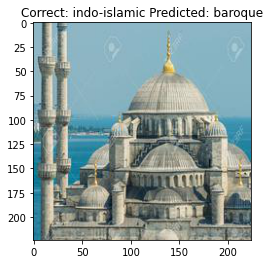

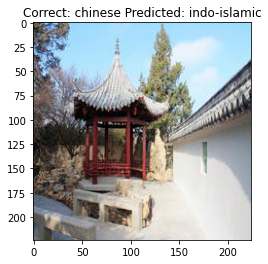

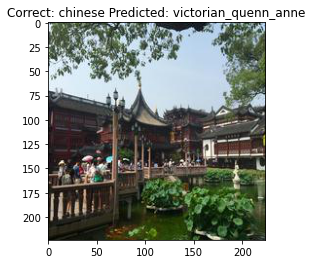

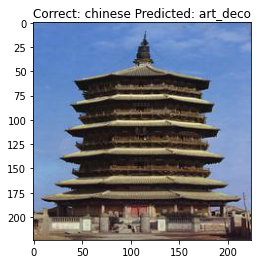

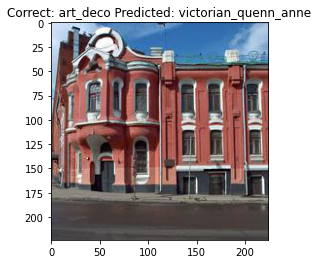

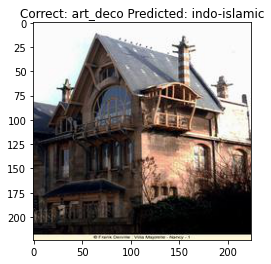

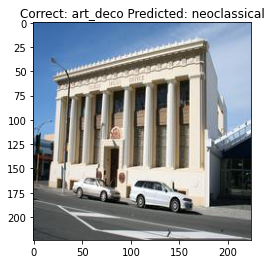

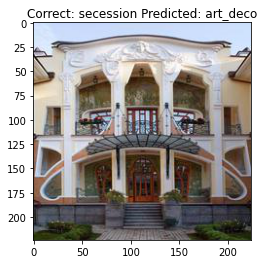

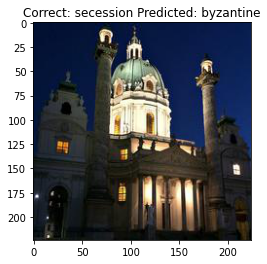

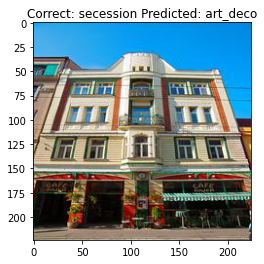

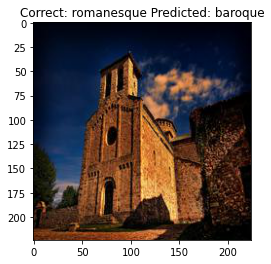

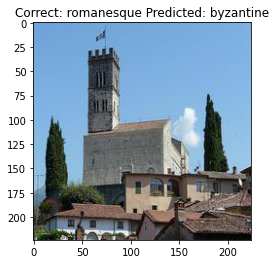

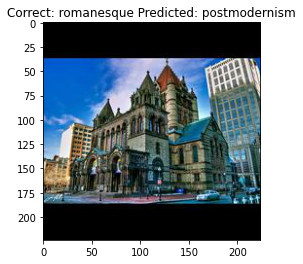

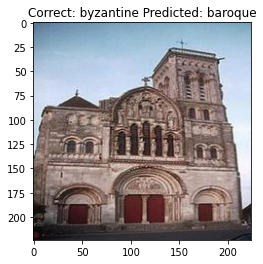

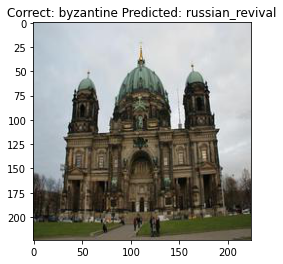

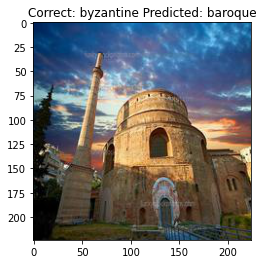

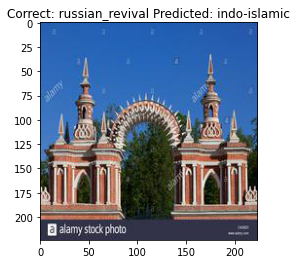

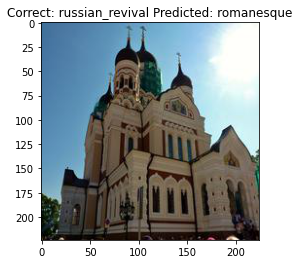

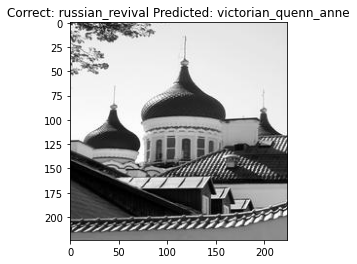

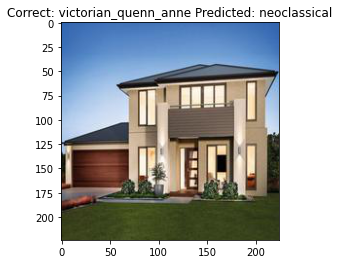

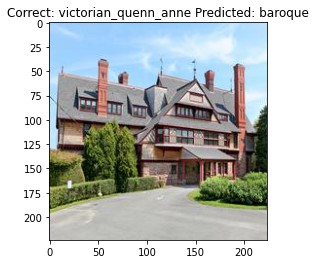

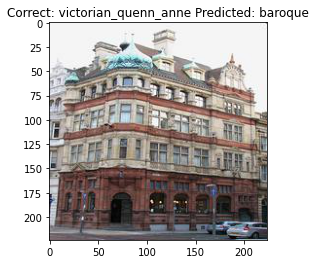

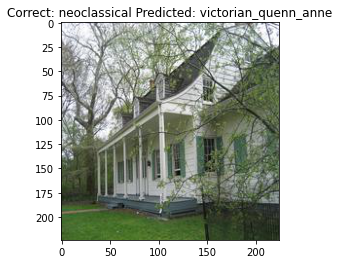

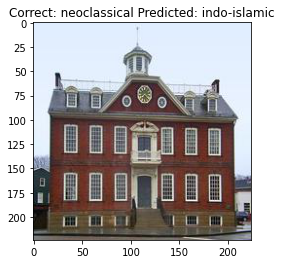

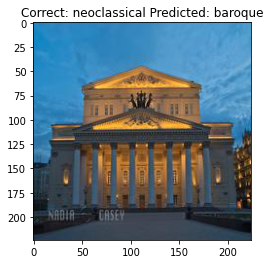

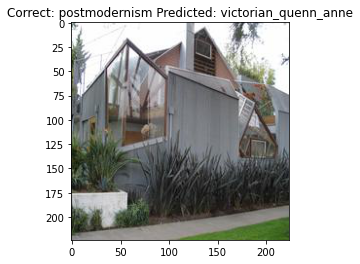

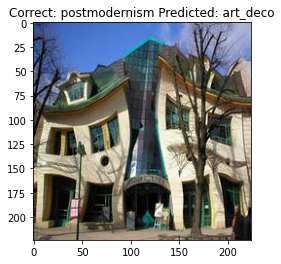

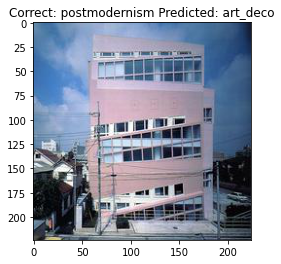

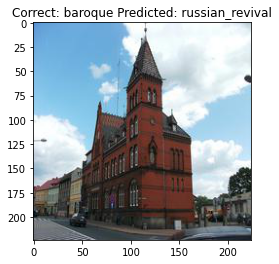

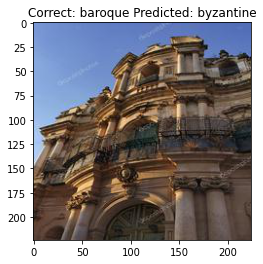

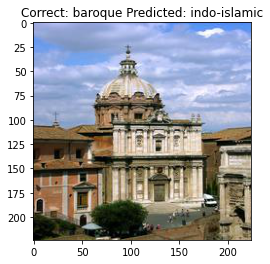

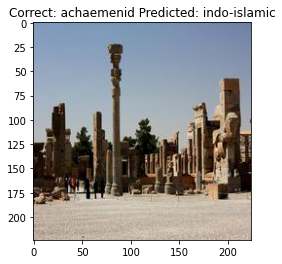

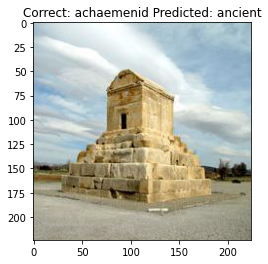

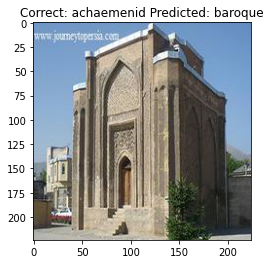

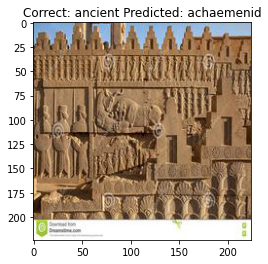

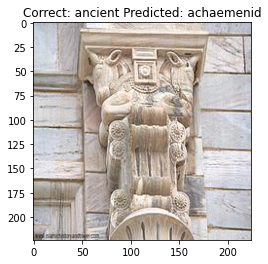

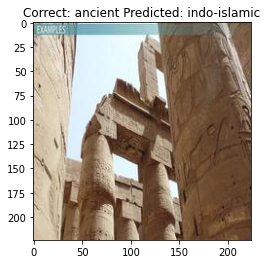

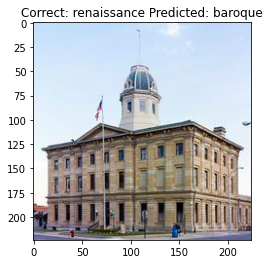

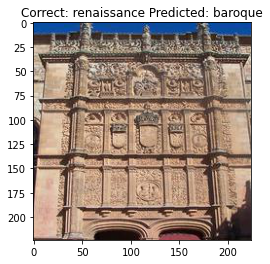

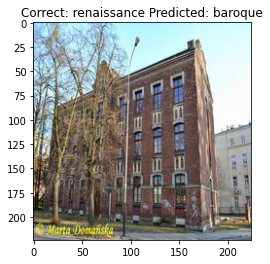

In [55]:
y_pred = model.predict(images_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = labels_test
labels = list(dataset['labels_mapping'].keys())
for c in range(14):
    count = 0
    for x, y_p, y_t in zip(images_test_before, y_pred, y_true):
        y_t = y_t.numpy()[0]
        if y_t == c:
            if (y_p != y_t) and count<3:
                count +=1
                show_image(x,labels[y_t],labels[y_p])

### Podsumowanie:
#### Testowane metody data augmentation:
- tf.image.flip_left_right - odwrócenie obrazu
- tf.image.rot90 - obrót o 90 stopni
- tf.image.random_brightness, 
	tf.image.random_contrast, 
	tf.image.random_saturation - zmiana jasności, kontrastu i intensywności barw

#### Wyniki:
- Wyniki polepszyły się przy zastosowaniu rotacji obrazu

#### Testowane metody regularyzacji:
- Dropout z parametrami [0.1, 0.2, 0.5]
- Weight decay z parametrami [0.001, 0.0001, 0.00001]

#### Wyniki:
- Wyniki zazwyczaj są lepsze przy zastosowaniu dropout
- Weight decay pogarsza wyniki

#### Wnioski:
- Zastosowane metody zapobiegają wystąpieniu overfittingu
- Najlepszy wnik FScore jaki udało się uzyskać to 0.412, w poprzednim zadaniu to 0.408, więc poprawa jest nieznaczna.
- Wyniki wszystkich przeprowadzonych eksperymentów znajdują się w plikach csv

